## PREDICTING THE MARKET VALUE OF FOOTBALLERS

**PROBLEM DESCRRIPTION:** Footballers are getting over-priced.  

In this notebook, I built a regression model to estimate a Footballer's actual worth. This will prevent the extortion of Football clubs. 

First, I investigated the predictors to indentify those that are highly statistically significant in order to use them to predict the market value of footballers accurately. 

In [19]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
import seaborn as sns

## Read the csv file and store as a DataFrame, View the first few rows

In [20]:
footballData = pd.read_csv('footballData.csv')
footballData.head(3)

,Player name,Position,Age,Market Value,NaN,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off
0,Kylian Mbappé,Right Winger,20,200,0,30,24,0,13,4,0,1,5,5
1,Lionel Messi,Right Winger,31,160,0,26,27,0,17,1,0,0,3,1
2,Harry Kane,Centre-Forward,25,150,0,36,21,0,9,5,0,0,4,5


In [21]:
footballData.shape

(500, 14)

The dataset has 14 columns (13 features and 1 target variable) and 500 rows (examples). 

**POTENTIAL PREDICTORS**
- Player name : name of footballer
- Position : role of the footballer on the pitch
- Age : how old the footballer is
- Market Value - amount the footballer is worth in the market
- Nan : Decimal points obtained from the market value while scraping the data
- Matches : the number of games played so far
- Goals : the number of times a footballer has scored a goal against the opponents so far
- Own Goals : the number of times a footballer has scored against his team so far
- Assists : the number of times a footballer has assisted another footballer to put the ball at the back of the net
- Yellow cards : the number of yellow cards received by a footballer
- Second Yellow cards : the number of times a player has received two yellow cards in a game
- Red Cards : the number of red cards received by a footballer
- Substituted on : the number of times a footballer has been brought in during the game
- Substituted off : the number of times a footballer has been taken off the pitch during the game

**RESPONSE/TARGET VARIABLE**
- Market Value: the worth of a footballer

### Drop uuncecesary columns and check for missing values

In [22]:
#Removing the Playername and Nan columns which are obvioulsy insignificat features
footballData = footballData.drop(['Player name', 'NaN'], axis = 1)

#Converting all the examples in the market value to millions as it is on the website scraped from 
footballData['Market Value'] = footballData['Market Value'] * 1000000

#Checking to see if their are any missing values
footballData.isnull().sum()

Position              0
Age                   0
Market Value          0
Matches               0
Goals                 0
Own Goals             0
Assists               0
Yellow cards          0
Second Yellow card    0
Red Cards             0
Substitued on         0
Substituted off       0
dtype: int64

### Check for the presence of a relational order in the POSITION variable; the only categorical variable.


Position is a categorical variable and would need to be encoded becauase Machine Learning models are based on mathematical equations. Due to my knowledge about the subject matter, I would be checking to see if their is actually a relational order in the Position categories.


In [23]:
#Creating a list of list containing the Positions and the corresponding Market Value

position = footballData['Position']
marketValue = footballData['Market Value']
posMar = pd.concat((position, marketValue), axis = 1, ignore_index = True)
posMar = posMar.to_dict('split')
listPosMar = posMar['data']
listPosMar[:10]

[['Right Winger', 200000000],
 ['Right Winger', 160000000],
 ['Centre-Forward', 150000000],
 ['Attacking Midfield', 150000000],
 ['Attacking Midfield', 140000000],
 ['Second Striker', 110000000],
 ['Attacking Midfield', 100000000],
 ['Centre-Forward', 100000000],
 ['Central Midfield', 90000000],
 ['Left Winger', 80000000]]

In [24]:
#Creating a dictionary from the list of list above to store the TOTAL market value for each unique position in the dataset

dicPosMar = {}
for i in range(len(listPosMar)):
    if listPosMar[i][0] in dicPosMar.keys():
        dicPosMar[listPosMar[i][0]] += listPosMar[i][1]
    else:
        dicPosMar[listPosMar[i][0]] = listPosMar[i][1]
dicPosMar

{'Right Winger': 2165000000,
 'Centre-Forward': 2509000000,
 'Attacking Midfield': 1558000000,
 'Second Striker': 349000000,
 'Central Midfield': 2868000000,
 'Left Winger': 2057000000,
 'Centre-Back': 2656000000,
 'Goalkeeper': 878000000,
 'Defensive Midfield': 1214000000,
 'Left-Back': 853000000,
 'Right-Back': 855000000,
 'Right Midfield': 75000000,
 'Left Midfield': 71000000}

In [25]:
#Creating a dictionary to store the total number of people in the dataset per position

numPerPos = {}
for i in range(len(listPosMar)):
    numPerPos.setdefault(listPosMar[i][0], 0)
    numPerPos[listPosMar[i][0]] += 1
numPerPos

{'Right Winger': 52,
 'Centre-Forward': 64,
 'Attacking Midfield': 39,
 'Second Striker': 8,
 'Central Midfield': 86,
 'Left Winger': 50,
 'Centre-Back': 79,
 'Goalkeeper': 24,
 'Defensive Midfield': 38,
 'Left-Back': 28,
 'Right-Back': 27,
 'Right Midfield': 2,
 'Left Midfield': 3}

In [26]:
#Creating a dictionary to store the average market value per position

aveValPerPos = {}
posList = list(numPerPos.keys())
for i in range(len(posList)):
    aveValPerPos.setdefault(posList[i], (round((dicPosMar[posList[i]]/numPerPos[posList[i]]), 2)))
aveValPerPos

{'Right Winger': 41634615.38,
 'Centre-Forward': 39203125.0,
 'Attacking Midfield': 39948717.95,
 'Second Striker': 43625000.0,
 'Central Midfield': 33348837.21,
 'Left Winger': 41140000.0,
 'Centre-Back': 33620253.16,
 'Goalkeeper': 36583333.33,
 'Defensive Midfield': 31947368.42,
 'Left-Back': 30464285.71,
 'Right-Back': 31666666.67,
 'Right Midfield': 37500000.0,
 'Left Midfield': 23666666.67}

In [27]:
#Preparing two lists containing the Positons and the corresponding Average market value per position for visualization

aveValPerPosList = []
for i in range(len(list(aveValPerPos.keys()))):
    tempList = []
    tempList.append(list(aveValPerPos.keys())[i])
    tempList.append(list(aveValPerPos.values())[i])
    aveValPerPosList.append(tempList)
x = []
y = []
for i in range(len(aveValPerPosList)):
    x.append(aveValPerPosList[i][0])
    y.append(aveValPerPosList[i][1])

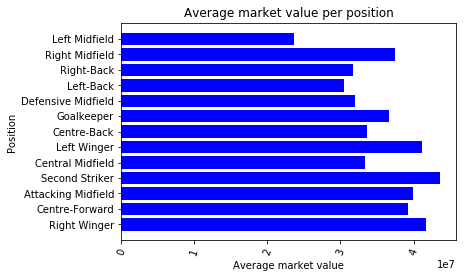

In [28]:
#Plotting a bar chart to show the relationship between the Position and the corresponding Average Market Value

plt.barh(x,y, color = 'blue')
plt.xticks(rotation = 70)
plt.ylabel('Position')
plt.xlabel('Average market value')
plt.title('Average market value per position')
plt.show()



It's hard to tell from the visualization above if their is actually any relational order in the Position variable. Since most soccer positions can be divided up into three major categories: **Strikers, midfielders, and defenders** , I classified the Position into the three categories to further investigate a relational order.



In [29]:
#Converting the positions into the main categories: Striker, Midfielder, Defender

footballData['newPosition'] = footballData.Position.map({'Right Winger':'Striker', 'Centre-Forward':'Striker',\
                                                         'Attacking Midfield':'Midfielder', 'Second Striker':'Striker',\
                                                         'Central Midfield':'Midfielder', 'Left Winger':'Striker',\
                                                         'Centre-Back':'Defender', 'Goalkeeper':'Defender',  \
                                                         'Defensive Midfield':'Midfielder', 'Left-Back':'Defender',\
                                                         'Right-Back':'Defender', 'Right Midfield':'Midfielder',\
                                                         'Left Midfield':'Midfielder'})
footballData.tail(3)

,Position,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosition
497,Left Winger,24,16000000,31,4,0,4,5,0,0,11,12,Striker
498,Goalkeeper,21,16000000,6,0,0,0,0,0,0,0,0,Defender
499,Right-Back,22,16000000,26,2,0,2,1,0,0,7,2,Defender


In [30]:
#Creating a list of list containing the new Positions and the corresponding Market Value

newPosition = footballData['newPosition']
marketValue = footballData['Market Value']
newPosMar = pd.concat((newPosition, marketValue), axis=1, ignore_index= True)
newPosMar = newPosMar.to_dict('split')
newListPosMar = newPosMar['data']
newListPosMar[:3]

[['Striker', 200000000], ['Striker', 160000000], ['Striker', 150000000]]

In [31]:
#Creating a dictionary from the list of list above to store the TOTAL market value for each unique new position in the dataset

newDicPosMar = {}
for i in range(len(newListPosMar)):
    if newListPosMar[i][0] in newDicPosMar.keys():
        newDicPosMar[newListPosMar[i][0]] += newListPosMar[i][1]
    else:
        newDicPosMar[newListPosMar[i][0]] = newListPosMar[i][1]
newDicPosMar

{'Striker': 7080000000, 'Midfielder': 5786000000, 'Defender': 5242000000}

In [32]:
#Creating a dictionary to store the total number of people in the dataset per new position

newNumPerPos = {}
for i in range(len(newListPosMar)):
    newNumPerPos.setdefault(newListPosMar[i][0], 0)
    newNumPerPos[newListPosMar[i][0]] += 1
newNumPerPos

{'Striker': 174, 'Midfielder': 168, 'Defender': 158}

In [33]:
#Creating a dictionary to store the average market value per new position

newAveValPerPos = {}
newPosList = list(newDicPosMar.keys())
for i in range(len(list(newPosList))):
    newAveValPerPos.setdefault(newPosList[i], (round((newDicPosMar[newPosList[i]]/newNumPerPos[newPosList[i]]), 2)))
newAveValPerPos

{'Striker': 40689655.17, 'Midfielder': 34440476.19, 'Defender': 33177215.19}

In [34]:
#Preparing two lists containing the Positons and the corresponding Average market value per new position for visualization

newAveValPerPosList = []
for i in range(len(list(newAveValPerPos.keys()))):
    newTempList = []
    newTempList.append(list(newAveValPerPos.keys())[i])
    newTempList.append(list(newAveValPerPos.values())[i])
    newAveValPerPosList.append(newTempList)
newX = []
newY = []
for i in range(len(newAveValPerPosList)):
    newX.append(newAveValPerPosList[i][0])
    newY.append(newAveValPerPosList[i][1])
newX, newY

(['Striker', 'Midfielder', 'Defender'],
 [40689655.17, 34440476.19, 33177215.19])

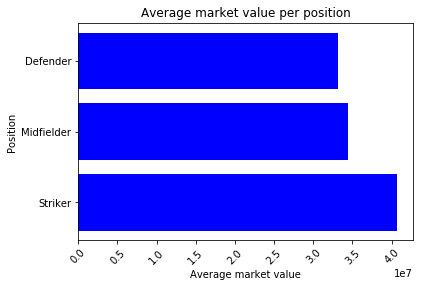

In [35]:
#Plotting a bar chart to show the relationship between the Position and the corresponding Average Market Value

plt.barh(newX,newY, color = 'blue')
plt.xticks(rotation = 45)
plt.ylabel('Position')
plt.xlabel('Average market value')
plt.title('Average market value per position')
plt.show()

On the average, Strikers are usually worth more than Midfielders and Midfielders are usually worth more than the Defeneders. This is as expected. Hence, I believe their is a relational order and therefore I would assign the highest priority to Strikers followed by Midfielders and then Defenders.

In [36]:
#Encoding the newPosition column with Strikers assisgned 2, Midfielders assigned 1 and Defenders assigned 0

'''footballData['newPosEncoded'] = footballData.newPosition.map({'Striker':2, 'Midfielder':1, 'Defender':0})'''

le = LabelEncoder()
footballData['newPosEncoded'] = le.fit_transform(footballData['newPosition'])
footballData.head()

,Position,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosition,newPosEncoded
0,Right Winger,20,200000000,30,24,0,13,4,0,1,5,5,Striker,2
1,Right Winger,31,160000000,26,27,0,17,1,0,0,3,1,Striker,2
2,Centre-Forward,25,150000000,36,21,0,9,5,0,0,4,5,Striker,2
3,Attacking Midfield,27,150000000,16,4,0,4,2,0,0,6,9,Midfielder,1
4,Attacking Midfield,26,140000000,34,9,0,5,1,0,0,9,14,Midfielder,1


## Exploratory Data Analysis

In [37]:
#Selecting only the numeric columns in the dataset
numFootballData = footballData.select_dtypes(include = ['number'])
numFootballData.head(3)

,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosEncoded
0,20,200000000,30,24,0,13,4,0,1,5,5,2
1,31,160000000,26,27,0,17,1,0,0,3,1,2
2,25,150000000,36,21,0,9,5,0,0,4,5,2


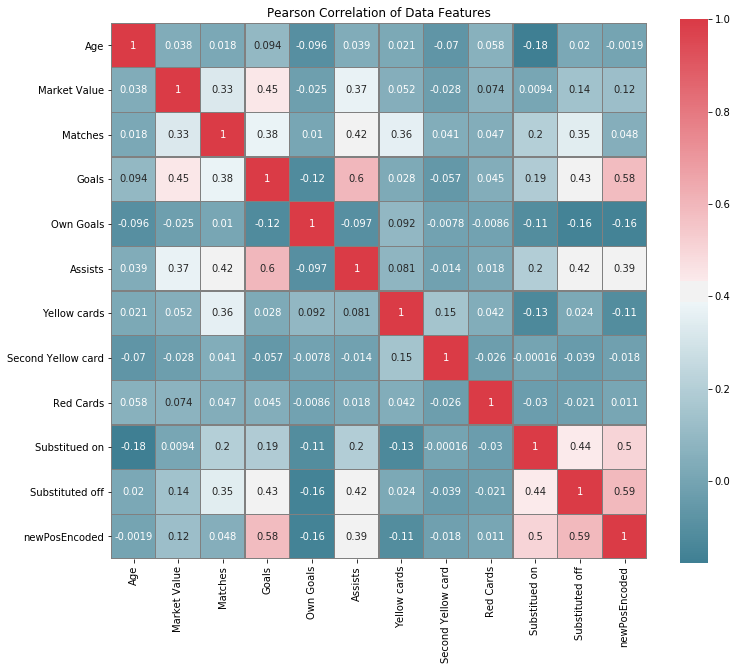

In [38]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Data Features')
sns.heatmap(numFootballData.iloc[:,:].astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, linecolor='grey', annot=True);

Text(0, 0.5, 'Market Value')

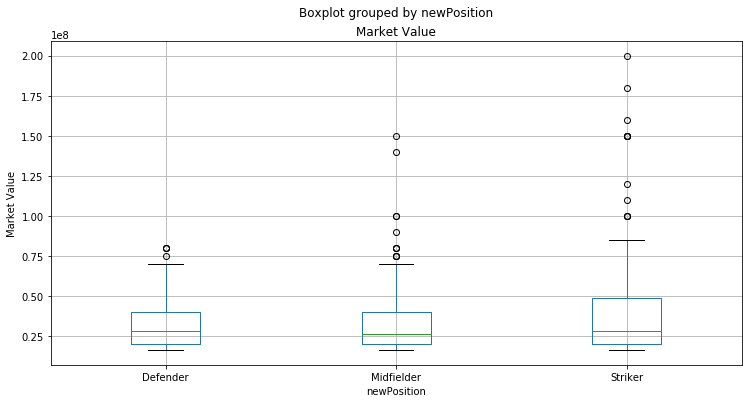

In [40]:
footballData.boxplot(column = 'Market Value', by = 'newPosition', figsize = (12,6))
plt.ylabel('Market Value')

Text(0, 0.5, 'Goals')

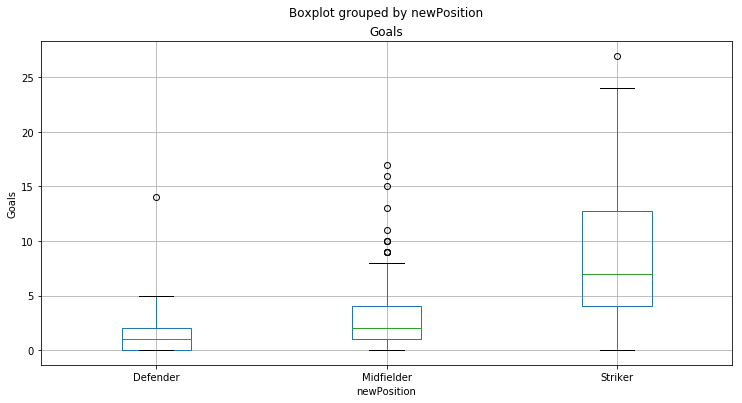

In [41]:
footballData.boxplot(column = 'Goals', by = 'newPosition', figsize = (12,6))
plt.ylabel('Goals')

Text(0, 0.5, 'Assists')

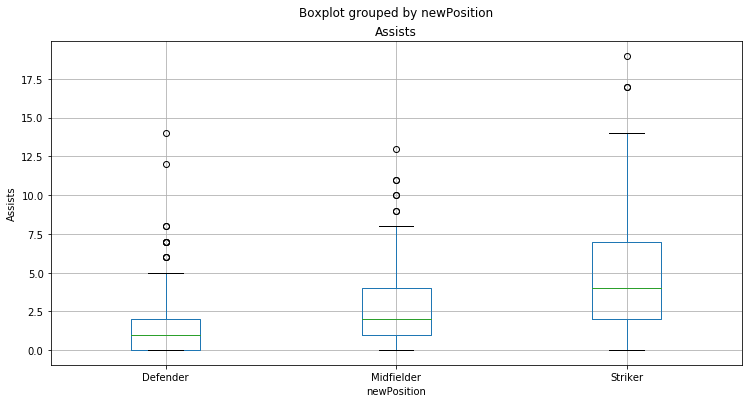

In [42]:
footballData.boxplot(column = 'Assists', by = 'newPosition', figsize = (12,6))
plt.ylabel('Assists')

Text(0, 0.5, 'Matches')

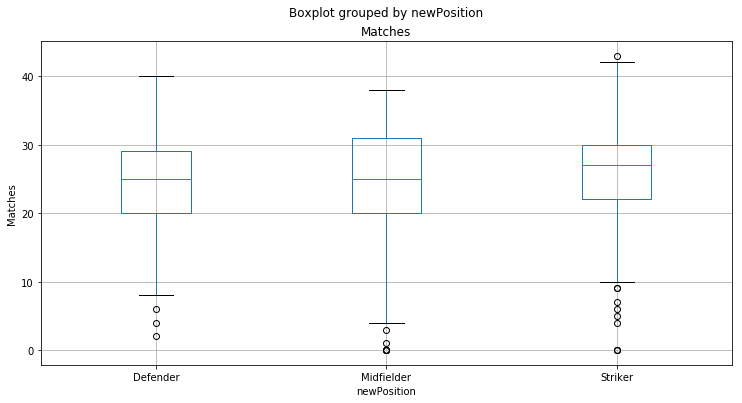

In [43]:
footballData.boxplot(column = 'Matches', by = 'newPosition', figsize = (12,6))
plt.ylabel('Matches')

Text(0, 0.5, 'Yellow cards')

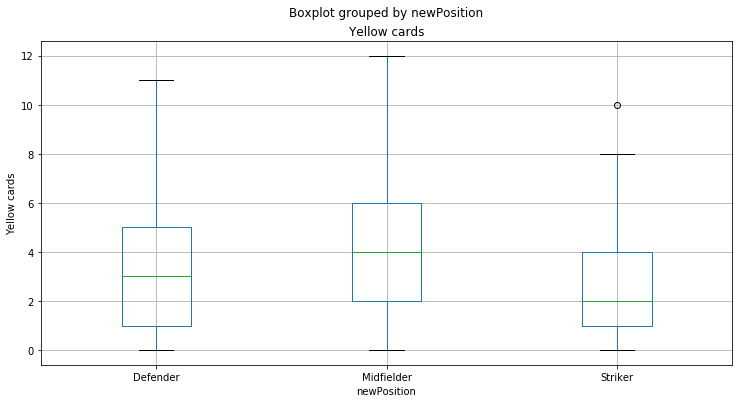

In [44]:
footballData.boxplot(column = 'Yellow cards', by = 'newPosition', figsize = (12,6))
plt.ylabel('Yellow cards')

In [45]:
footballData.describe().round(2)

,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosEncoded
count,500.00,5.000000e+02,500.0,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,25.28,3.621600e+07,24.6,4.23,0.04,3.20,3.19,0.06,0.06,4.04,5.55,1.03
std,3.25,2.502458e+07,7.9,5.09,0.20,3.27,2.48,0.26,0.24,3.90,4.54,0.82
min,18.00,1.600000e+07,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,23.00,2.000000e+07,21.0,1.00,0.00,1.00,1.00,0.00,0.00,1.00,2.00,0.00
50%,25.00,2.800000e+07,26.0,2.00,0.00,2.00,3.00,0.00,0.00,3.00,5.00,1.00
75%,28.00,4.000000e+07,30.0,6.00,0.00,5.00,5.00,0.00,0.00,6.00,8.00,2.00
max,33.00,2.000000e+08,43.0,27.00,1.00,19.00,12.00,2.00,1.00,17.00,26.00,2.00


In [46]:
#Splitting the Market value into quartiles - Converting into a categorical variable
for i in range(len(footballData)):
    if footballData.loc[i,'Market Value'] < 20000000:
        footballData.loc[i,'Market Value category'] = 'Low Earners'
    elif footballData.loc[i, 'Market Value'] >= 20000000 and footballData.loc[i, 'Market Value'] < 28000000:
        footballData.loc[i, 'Market Value category'] = 'Moderate Earners'
    elif footballData.loc[i, 'Market Value'] >= 28000000 and footballData.loc[i, 'Market Value'] < 40000000:
        footballData.loc[i, 'Market Value category'] = 'High Earners'
    elif footballData.loc[i, 'Market Value'] >= 40000000 and footballData.loc[i, 'Market Value'] < 200000000:
        footballData.loc[i, 'Market Value category'] = 'Very High Earners'

In [47]:
footballData.tail()

,Position,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosition,newPosEncoded,Market Value category
495,Left-Back,26,17000000,30,1,0,4,5,0,0,1,5,Defender,0,Low Earners
496,Centre-Back,27,17000000,22,0,0,0,5,0,0,0,4,Defender,0,Low Earners
497,Left Winger,24,16000000,31,4,0,4,5,0,0,11,12,Striker,2,Low Earners
498,Goalkeeper,21,16000000,6,0,0,0,0,0,0,0,0,Defender,0,Low Earners
499,Right-Back,22,16000000,26,2,0,2,1,0,0,7,2,Defender,0,Low Earners


In [48]:
mvCategory = footballData.groupby('Market Value category').mean()
mvCategory

,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosEncoded
Market Value category,,,,,,,,,,,,
High Earners,25.052632,3.198947e+07,25.073684,3.968421,0.052632,2.957895,3.442105,0.147368,0.084211,3.831579,5.621053,0.947368
Low Earners,25.089744,1.760256e+07,21.794872,2.641026,0.025641,2.538462,2.833333,0.012821,0.051282,4.064103,4.782051,1.012821
Moderate Earners,25.420118,2.207692e+07,22.142012,3.284024,0.047337,2.609467,3.065089,0.047337,0.035503,4.017751,5.124260,1.041420
Very High Earners,25.407643,6.219745e+07,28.331210,6.082803,0.031847,4.242038,3.343949,0.044586,0.070064,4.159236,6.337580,1.076433


Text(0.5, 1.0, 'Average number of Matches per market value category')

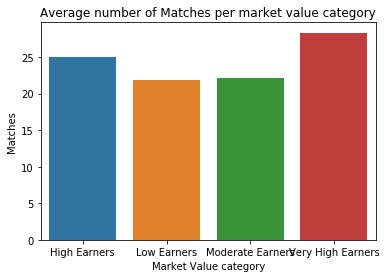

In [49]:
sns.barplot(x = mvCategory.index, y = 'Matches', data = mvCategory)
plt.title('Average number of Matches per market value category')

Text(0.5, 1.0, 'Average number of Goals per market value category')

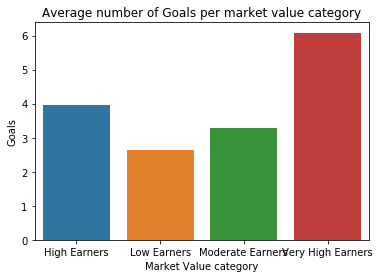

In [50]:
sns.barplot(x = mvCategory.index, y = 'Goals', data = mvCategory)
plt.title('Average number of Goals per market value category')

Text(0.5, 1.0, 'Average number of Assists per market value category')

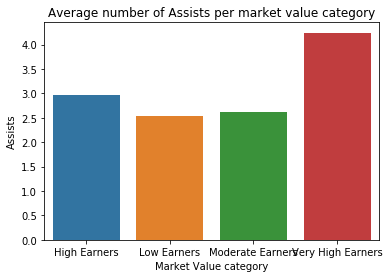

In [51]:
sns.barplot(x = mvCategory.index, y = 'Assists', data = mvCategory)
plt.title('Average number of Assists per market value category')

Text(0.5, 1.0, 'Average number of Yellow cards per market value category')

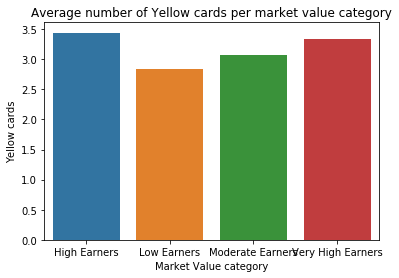

In [287]:
sns.barplot(x = mvCategory.index, y = 'Yellow cards', data = mvCategory)
plt.title('Average number of Yellow cards per market value category')

Text(0.5, 1.0, 'Average Age per market value category')

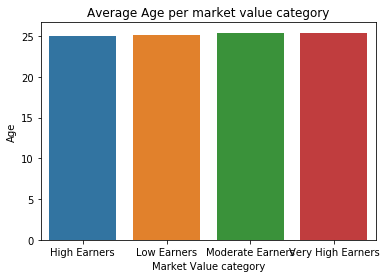

In [292]:
sns.barplot(x = mvCategory.index, y = 'Age', data = mvCategory)
plt.title('Average Age per market value category')

## Create DATAFRAMES for the PREDICTORS and RESPONSE VARIABLES

In [78]:
#Creating a copy of the dataset

copyFootballData = footballData.copy(deep = True)

In [79]:
#Creating the features and the target variables Dataframe: copyFootballDataX and copyFootballDatay

copyFootballDataX = copyFootballData.drop(['Position', 'Market Value', 'newPosition'], axis = 1)
copyFootballDatay = copyFootballData['Market Value']
copyFootballDataX.head()

,Age,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosEncoded
0,20,30,24,0,13,4,0,1,5,5,2
1,31,26,27,0,17,1,0,0,3,1,2
2,25,36,21,0,9,5,0,0,4,5,2
3,27,16,4,0,4,2,0,0,6,9,1
4,26,34,9,0,5,1,0,0,9,14,1


### Run the BACKWARD ELIMINATION ALGORITHM

To automatically select the highly statistically significant predictive variables, I used the Backward Elimination Algorithm (Stepwise Regression). The step by step process include:

- Step 1 : Select a significance level to stay in the model (I arbitrarily chose 0.05 as the sigbificance level)
- Step 2 : Fit the model with all the possible predictors (All-in)
- Step 3 : Consider the predictor with the highest P-value. If the P-value is greater than the signficance level, go to step 4, else end the program
- Step 4 : Remove the predictor
- Step 5 : Fit model without this variable and go back to step 3

I used the statsmodels library to implement this algorithm. Unlike the LinearRegression class from scikit-learn that automatically helps to add the intercept(constant term), the statsmodels requires this to be done manually.

In [80]:
#Adding the intercept term to the features dataframe

intercept = pd.Series(np.ones((500,)).astype(int))
copyFootballDataX = pd.concat((intercept.rename('intercept'),copyFootballDataX), axis = 1)
copyFootballDataX.head()

,intercept,Age,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off,newPosEncoded
0,1,20,30,24,0,13,4,0,1,5,5,2
1,1,31,26,27,0,17,1,0,0,3,1,2
2,1,25,36,21,0,9,5,0,0,4,5,2
3,1,27,16,4,0,4,2,0,0,6,9,1
4,1,26,34,9,0,5,1,0,0,9,14,1


Before running the Backward Elimination Algorithm:

It would be appropriate to conduct an hypothesis test by fitting all the potential predictors and check if their is actually a relationship between the predictors and the response variable. This can be achieved using the F-statistic. 
The reason for doing this is because their is a probability that some of the predictors will show a relationship by chance using the individual p-values of the predictors.

If F-statistic is 1, then we fail to reject the null hypothesis, that is, their is no relationship between the predictors and the response variable.
However, if F-statistic is greater than 1, then we reject the null hypothesis, meaning that their is a relationship between the predictors and the response variable.

In [82]:
model = sm.OLS(copyFootballDatay, copyFootballDataX).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market Value   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     16.02
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           6.32e-27
Time:                        10:28:42   Log-Likelihood:                -9149.6
No. Observations:                 500   AIC:                         1.832e+04
Df Residuals:                     488   BIC:                         1.837e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept           2.318e+07   8.71e+06      2.661      0.008    6.07e+06    4.03e+07
Age                -1.386e+05    3.1e+05     -0.447      0.655   -7.47e+05     4.7e+05
Matches             5.133e+05   1.68e+05      3.048      0.002    1.82e+05    8.44e+05
Goals               1.958e+06   2.94e+05      6.667      0.000    1.38e+06    2.53e+06
Own Goals           8.091e+05   5.09e+06      0.159      0.874   -9.19e+06    1.08e+07
Assists             1.167e+06   3.89e+05      2.999      0.003    4.02e+05    1.93e+06
Yellow cards       -5.121e+05   4.39e+05     -1.166      0.244   -1.37e+06    3.51e+05
Second Yellow card -5.513e+05   3.78e+06     -0.146      0.884   -7.98e+06    6.88e+06
Red Cards           5.017e+06   4.11e+06      1.221      0.223   -3.06e+06    1.31e+07
Substitued on      -3.364e+05   3.21e+05     -1.047      0.296   -9.68e+05    2.95e+05
Substituted off    -2.538e+05   2.96e+05     -0.856      0.392   -8.36e+05    3.29e+05
newPosEncoded      -3.891e+06      2e+06     -1.942      0.053   -7.83e+06    4.57e+04
==============================================================================
Omnibus:                      186.255   Durbin-Watson:                   0.540
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.994
Skew:                           1.637   Prob(JB):                    7.75e-172
Kurtosis:                       8.206   Cond. No.                         335.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

F-statistic: 16.03

This indicates the presence of some relationship between the predictors and the response variable.

Next, we decide on the important variables.

In [83]:
#Implementing the Baackward Elimination Algorithm


#Arbitrarily selecting the significance level as 0.05 to stay in the model
sigLevel = 0.05

#Fitting the model with all the possible predictors
model = sm.OLS(copyFootballDatay, copyFootballDataX).fit()
pVals = model.pvalues

#Steps 3 to 5 inside the  while loop
while pVals[np.argmax(pVals)] > sigLevel:
    copyFootballDataX = copyFootballDataX.drop([np.argmax(pVals)], axis = 1)
    model = sm.OLS(copyFootballDatay, copyFootballDataX).fit()
    pVals = model.pvalues

#Printing the summary of the final model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market Value   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     43.06
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           5.25e-31
Time:                        10:35:58   Log-Likelihood:                -9152.0
No. Observations:                 500   AIC:                         1.831e+04
Df Residuals:                     495   BIC:                         1.834e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       2.07e+07   3.61e+06      5.734      0.000    1.36e+07    2.78e+07
Matches        3.656e+05   1.42e+05      2.579      0.010    8.71e+04    6.44e+05
Goals          2.078e+06    2.8e+05      7.425      0.000    1.53e+06    2.63e+06
Assists        1.115e+06   3.85e+05      2.897      0.004    3.59e+05    1.87e+06
newPosEncoded -5.662e+06   1.51e+06     -3.740      0.000   -8.64e+06   -2.69e+06
==============================================================================
Omnibus:                      185.151   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.436
Skew:                           1.631   Prob(JB):                    4.13e-169
Kurtosis:                       8.156   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hence, the highly statistically signficant features are:

- Matches 
- Goals
- Assists
- newPoistionEncoded (Position)

This makes sense.

Interpretation of some results from the table able:
- **coef**: The coefficients for the predictors correspond to the change in the market value for a one unit change in the particular predictor. For example, a one unit change in the number of **GOALS** corresponds to an increase in the **MARKET VALUE** by **2,078,000**
- **t**: This is the t-statistic used to conduct the hypothesis test to determine if their is a relationship between the predictor and the response.
Null hypothesis: Their is no relationship between the predictor and response, meaning that the coefficient is zero.
Alternative hypothesis: Presence of a relationship between the predictor and response, meaning that the coefficient is a non-zero constant.
The t-statistic defines the ratio of the departure of the estimated value of a parameter from it's hpothesized value to the standard error. Hence, if the absolute value of the t-statistic is between 0 and 1 (meaning that the absolute standard error is greater than the absolute difference between the estimated value and it's hypothesized value), then we fail to reject the null hypothesis because their is a probability that the estimate is zero. But, if the absolute value of the t-statistic is greater than 1, then we reject the null hypothesis.
- **P>|t|**: This is the corresponding p-values for the t-statistic. p-values are defined as the probability of obtaining the value we have given that the null-hypothesis is true (or by chance). Hence, we have a big value for p-value, then it means that that the corresponding value could have been due to chance.
- **[0.025 0.975]**: This corresponds to a confidence interval of 2.5% to 97.5%.
- **R-squared**: This is the proportion of the variance of the response explained by the predictors. R-squared is biased because it increases for every new variable. This is because the Least squares method mimimizes the Residual sum of squares for every new variable added even if the variable isn't statistically significant while keeping the total sum of squares constant. Typically, the values should range between 0 and 1 except if the regression line is worse than the average line drawn through the model, then we can have a negative value but it can never exceed 1. Our model has an R-squared of 0.258 meaning that only 25.8% of the variance of the response has been explained by our predictors.
- **Adj. R-squared**: This has a penalty factor that penalizes for adding a variable that is not statistically significant. Hence, this is a better metric to consider over the R-squared.

## Check for Linear Model Assumptions

- **LINEARITY**:
    This means that the change in the response due to a one-unit change in the predictor is constant.

    * PROBLEM: If the true relationship between the response and the pedictors is not linear, then the accuracy of the model is significantly reduced.
    
    * DETECTION: Residual plot will be used to check for NON-linearity. In simple linear regression, this is a plot of the residuals against the single predictor while in the multiple linear regression, it's a plot of the residuals against the predicted/fitted value. If the plot shows no pattern, then the linear assumption has been justified.
    
    * SOLUTION: Extend the linear model to accomodate the non-linear relationship. This can be achieved by transforming the predictors into polynomials.
    
- **HOMOSCEDASTICIY**: This means that the error terms should have a constant variance.
    * PROBLEM: This may give an unwarranted sense of confidence in our model. Standard error of the coefficient estimates rely upon this assumption. Consequently, Hypothesis test and Confidence Intervals for the coefficient estimates which use the standard errors for their calculations rely upon this assumption. 
    * DETETION: Presence of a funnel shape in the Residual plot.
    * SOLUTION: Transform the response using a concave function such as the logarithm or the square root of the response.
    
- **INDEPENDENCE OF ERROR TERMS**: This means that the error terms should be uncorrelated. That is, if the nth term of the error is positive, this should provide no information about the sign of the (n+1)th term.
    * PROBLEM: This may give an unwarranted sense of confidence in our model. Standard error of the coefficient estimates rely upon this assumption. Consequently, Hypothesis test and Confidence Intervals for the coefficient estimates which use the standard errors for their calculations rely upon this assumption. 
    * DETECTION: Plot the residuals as a function of time. If the error terms are uncorrelated, there should be no discernible pattern.
    * SOLUTION: Transform the response using a concave function such as the logarithm or the square root of the response.

- **ABSENCE OF MULTICOLLINEARITY**: 
    This means that the predictors are not related to one another.
    * PROBLEM: It can be difficult to determine how each variable is associated with the response, thereby reducing the accuracy of the coefficient estimates. This causes the standard error to increase. Consequently, the power of the hypothesis test, the probability of correctly detecting a non-zero coefficient, is reduced.
    * DETECTION:  The Variance Inflation Factor (VIF) will be used to check. Smallest possible value of the VIF is 1, which indicates complete absence of multicollinearity. Typically, there is a small amount of collinearity among predictors. Therefore, if only the Variance Inflation Factor is greater than 5, then multicolinearity is likely present.
    * SOLUTION:
        * Drop one of the problematic variables from the regression, since the information provided by a collinear variable is redundant in the presence of other variables. 
        * Combine collinear variables into a single predictor.

In [92]:
#creating arrays to check for assumptions

X = copyFootballDataX.iloc[:,[1,2,3,4]].values
y = copyFootballDatay.iloc[:,].values
X.shape,y.shape

((500, 4), (500,))

In [93]:
#Splitting the dataset into training and test set

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state = 0)
X_train.shape,y_train.shape

((400, 4), (400,))

In [94]:
#Fitting the Multiple Linear Regression model, and calculating the residuals

regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
residual = y_test - y_pred
residual = pd.Series(residual)

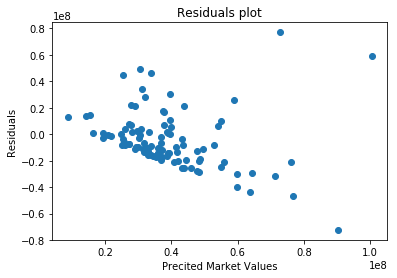

In [89]:
#Testing for Linearity and Homoscedasticity using the Residual plot
plt.scatter(y_pred, residual)
plt.xlabel('Precited Market Values')
plt.ylabel('Residuals')
plt.title('Residuals plot')
plt.show()

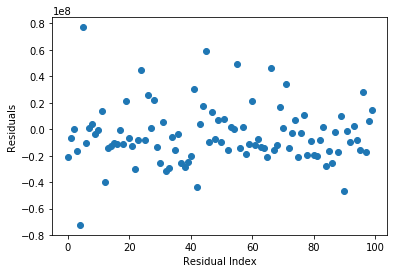

In [90]:
#Testing for Independence of errors
plt.scatter(residual.index, residual.values)
plt.xlabel('Residual Index')
plt.ylabel('Residuals')
plt.show()

In [91]:
#Detecting multicollinearity using Variance Inflation Factor

vif = pd.DataFrame()
vif["features"] = ['Matches', 'Goals', 'Assits', 'Position']
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif.round(2)

,features,VIF Factor
0,Matches,3.00
1,Goals,3.36
2,Assits,3.27
3,Position,3.31


- The residual plot shows some pattern. Therefore, presence of some non-linear relationship which is typical in practice.
- Absence of multicollinearity assumption has been met.

### POLYNOMIAL REGRESSION: Extending the linear model to accomodate for the non-linear relationship 

Finally, Building a Polynomial Linear Regression model.

In [109]:
#Creating Polynomial Regressors

polyReg = PolynomialFeatures(degree = 2)
polyX = polyReg.fit_transform(X[:,[1,2]])
polyX = np.append(polyX, X[:,[0,3]], axis = 1)

In [97]:
#splitting the dataset into training and test set

trainPolyX, testPolyX, trainPolyy, testPolyy = train_test_split(polyX, y, test_size = 0.2, random_state = 0) 

In [99]:
#fitting the model and displaying the summary

modelPoly = sm.OLS(trainPolyy, trainPolyX).fit()
modelPoly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     32.88
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           6.76e-36
Time:                        11:27:15   Log-Likelihood:                -7294.5
No. Observations:                 400   AIC:                         1.460e+04
Df Residuals:                     392   BIC:                         1.464e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.889e+07   3.73e+06      5.060      0.000    1.15e+07    2.62e+07
x1         -8.818e+05    7.7e+05     -1.145      0.253    -2.4e+06    6.32e+05
x2         -7.942e+05    8.6e+05     -0.924      0.356   -2.48e+06    8.96e+05
x3          5.429e+04   4.49e+04      1.210      0.227   -3.39e+04    1.42e+05
x4          3.442e+05   8.28e+04      4.159      0.000    1.81e+05    5.07e+05
x5         -1.452e+04   8.65e+04     -0.168      0.867   -1.85e+05    1.56e+05
x6          6.734e+05   1.54e+05      4.383      0.000    3.71e+05    9.75e+05
x7         -1.938e+06   1.71e+06     -1.136      0.256   -5.29e+06    1.42e+06
==============================================================================
Omnibus:                      130.950   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.795
Skew:                           1.396   Prob(JB):                    9.05e-116
Kurtosis:                       7.898   Cond. No.                         417.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# END OF NOTEBOOK